In [2]:
!pip install -U vnstock

In [3]:
## Có thể gọi các class chi tiết trong thư viện thay vì sử dụng cấp cao nhất là Vnstock
from vnstock import Vnstock
from vnstock import Listing, Quote, Company, Finance, Trading, Screener


## 👋 Chào mừng bạn đến với Vnstock!

Cảm ơn bạn đã sử dụng package phân tích chứng khoán #1 tại Việt Nam

* Tài liệu: [Sổ tay hướng dẫn](https://vnstocks.com/docs/category/s%E1%BB%95-tay-h%C6%B0%E1%BB%9Bng-d%E1%BA%ABn)
* Cộng đồng: [Nhóm Facebook](https://www.facebook.com/groups/vnstock.official)

Khám phá các tính năng mới nhất và tham gia cộng đồng để nhận hỗ trợ.
                

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# Danh sách mã muốn so sánh
symbols = ["VIC","VCB","FPT","HPG","PLX","MWG"]
# 6 mã cổ phiếu có khả năng vốn hóa cao nhất sàn HOSE tính đến năm 2021
# Khoảng thời gian (chỉnh theo ý bạn)
start = "2013-01-08" 
end = "2020-12-30"


## Bước 1: Khởi tạo đối tượng stock cho từng mã

In [20]:
# Khởi tạo đối tượng stock cho từng mã
stocks = {}
for symbol in symbols:
    try:
        stocks[symbol] = Vnstock().stock(symbol=symbol, source='VCI')
        print(f"✓ Khởi tạo thành công: {symbol}")
    except Exception as e:
        print(f"✗ Lỗi khởi tạo {symbol}: {e}")

print(f"\n✅ Đã khởi tạo {len(stocks)}/{len(symbols)} mã cổ phiếu")

✓ Khởi tạo thành công: VIC
✓ Khởi tạo thành công: VCB
✓ Khởi tạo thành công: VCB
✓ Khởi tạo thành công: FPT
✓ Khởi tạo thành công: FPT
✓ Khởi tạo thành công: HPG
✓ Khởi tạo thành công: HPG
✓ Khởi tạo thành công: PLX
✓ Khởi tạo thành công: PLX
✓ Khởi tạo thành công: MWG

✅ Đã khởi tạo 6/6 mã cổ phiếu
✓ Khởi tạo thành công: MWG

✅ Đã khởi tạo 6/6 mã cổ phiếu


## Bước 2: Trích xuất dữ liệu lịch sử giá

In [21]:
# Lấy dữ liệu lịch sử cho tất cả các mã
data_dict = {}
failed_symbols = []

for symbol in symbols:
    try:
        print(f"Đang tải {symbol}...", end=" ")
        df = stocks[symbol].quote.history(start=start, end=end, interval='1D')
        
        if df is not None and not df.empty:
            data_dict[symbol] = df
            print(f"✓ {len(df)} dòng dữ liệu")
        else:
            print(f"✗ DataFrame rỗng")
            failed_symbols.append(symbol)
    except Exception as e:
        print(f"✗ Lỗi: {e}")
        failed_symbols.append(symbol)

print(f"\n{'='*60}")
print(f"✅ Thành công: {len(data_dict)}/{len(symbols)} mã")
if failed_symbols:
    print(f"✗ Thất bại: {', '.join(failed_symbols)}")
    
# Hiển thị thông tin mẫu
if data_dict:
    first_symbol = list(data_dict.keys())[0]
    print(f"\n📊 Mẫu dữ liệu từ {first_symbol}:")
    print(f"Columns: {data_dict[first_symbol].columns.tolist()}")
    print(f"\nFirst 3 rows:")
    print(data_dict[first_symbol].head(3))

Đang tải VIC... ✓ 1993 dòng dữ liệu
Đang tải VCB... ✓ 1993 dòng dữ liệu
Đang tải VCB... ✓ 1993 dòng dữ liệu
Đang tải FPT... ✓ 1993 dòng dữ liệu
Đang tải FPT... ✓ 1993 dòng dữ liệu
Đang tải HPG... ✓ 1993 dòng dữ liệu
Đang tải HPG... ✓ 1993 dòng dữ liệu
Đang tải PLX... ✓ 1993 dòng dữ liệu
Đang tải PLX... ✓ 929 dòng dữ liệu
Đang tải MWG... ✓ 929 dòng dữ liệu
Đang tải MWG... ✓ 1621 dòng dữ liệu

✅ Thành công: 6/6 mã

📊 Mẫu dữ liệu từ VIC:
Columns: ['time', 'open', 'high', 'low', 'close', 'volume']

First 3 rows:
        time   open   high    low  close  volume
0 2013-01-08  17.97  18.08  17.76  17.97  363210
1 2013-01-09  17.97  17.97  17.65  17.65   81350
2 2013-01-10  17.65  17.65  17.23  17.65  120980
✓ 1621 dòng dữ liệu

✅ Thành công: 6/6 mã

📊 Mẫu dữ liệu từ VIC:
Columns: ['time', 'open', 'high', 'low', 'close', 'volume']

First 3 rows:
        time   open   high    low  close  volume
0 2013-01-08  17.97  18.08  17.76  17.97  363210
1 2013-01-09  17.97  17.97  17.65  17.65   81350
2 2

## Bước 3: Tạo DataFrame giá đóng cửa tổng hợp

In [22]:
# Gộp giá đóng cửa của tất cả các mã vào một DataFrame
prices = pd.DataFrame()

for symbol, df in data_dict.items():
    # Tìm cột time/date
    date_col = None
    for col in ['time', 'date', 'Date', 'trade_date']:
        if col in df.columns:
            date_col = col
            break
    
    # Tìm cột close
    close_col = None
    for col in ['close', 'Close', 'price']:
        if col in df.columns:
            close_col = col
            break
    
    if date_col and close_col:
        temp_df = df.copy()
        temp_df[date_col] = pd.to_datetime(temp_df[date_col])
        temp_df = temp_df.set_index(date_col).sort_index()
        prices[symbol] = pd.to_numeric(temp_df[close_col], errors='coerce')
    else:
        print(f"⚠️ {symbol}: Không tìm thấy cột date hoặc close")

# Xóa các hàng có tất cả giá trị NaN
prices = prices.dropna(how='all')

print(f"📊 DataFrame giá đóng cửa:")
print(f"Shape: {prices.shape} (rows x columns)")
print(f"Khoảng thời gian: {prices.index.min()} đến {prices.index.max()}")
print(f"Số ngày giao dịch: {len(prices)}")
print(f"\n{prices.head()}")
print(f"\n{prices.tail()}")

# Kiểm tra dữ liệu thiếu
print(f"\n📈 Thống kê dữ liệu thiếu:")
print(prices.isna().sum())

📊 DataFrame giá đóng cửa:
Shape: (1993, 6) (rows x columns)
Khoảng thời gian: 2013-01-08 00:00:00 đến 2020-12-30 00:00:00
Số ngày giao dịch: 1993

              VIC   VCB   FPT   HPG  PLX  MWG
time                                         
2013-01-08  17.97  7.45  4.31  1.28  NaN  NaN
2013-01-09  17.65  7.50  4.42  1.27  NaN  NaN
2013-01-10  17.65  7.69  4.48  1.28  NaN  NaN
2013-01-11  17.76  7.59  4.41  1.27  NaN  NaN
2013-01-14  17.76  7.55  4.28  1.24  NaN  NaN

              VIC    VCB    FPT    HPG    PLX    MWG
time                                                
2020-12-24  93.96  42.36  24.90  16.84  45.31  37.32
2020-12-25  94.13  42.49  25.16  17.18  45.66  37.90
2020-12-28  94.13  42.66  25.29  17.51  47.12  37.51
2020-12-29  94.67  43.18  25.60  17.53  47.03  37.48
2020-12-30  96.45  42.62  25.38  17.24  47.21  37.51

📈 Thống kê dữ liệu thiếu:
VIC       0
VCB       0
FPT       0
HPG       0
PLX    1064
MWG     372
dtype: int64


## Bước 4: Trực quan hóa giá cổ phiếu

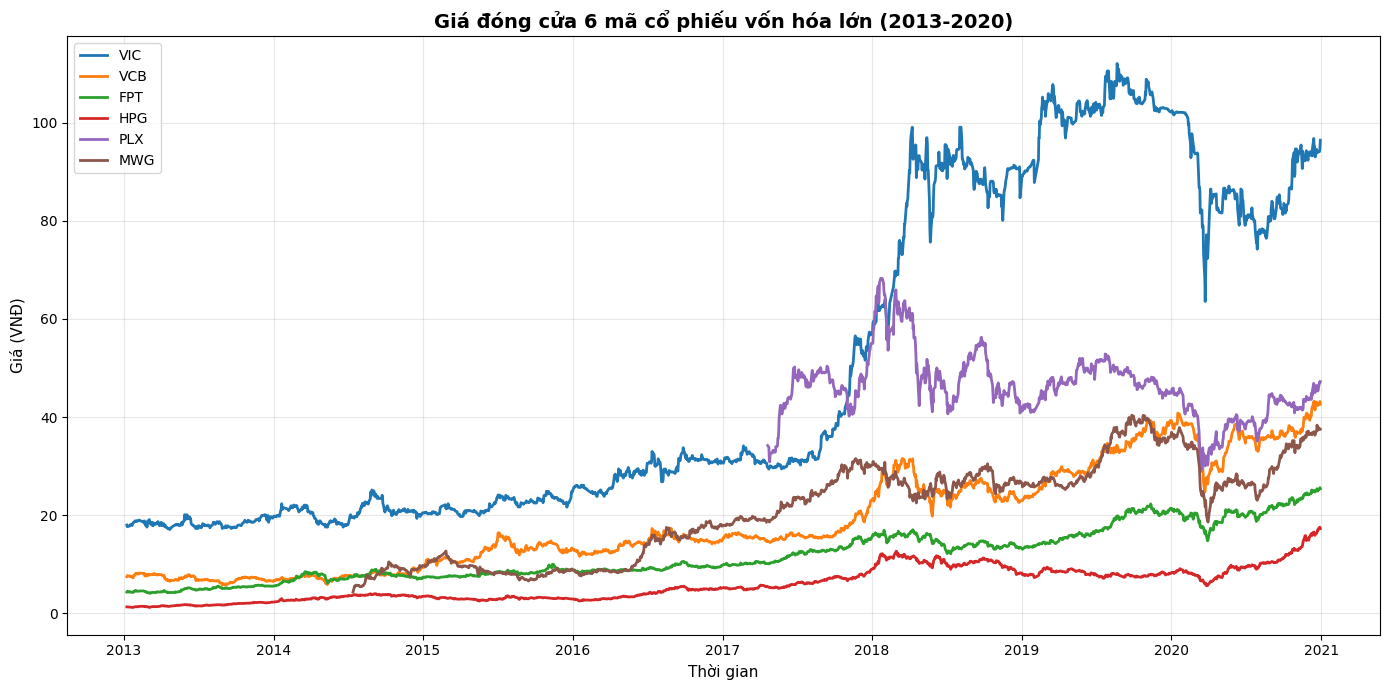

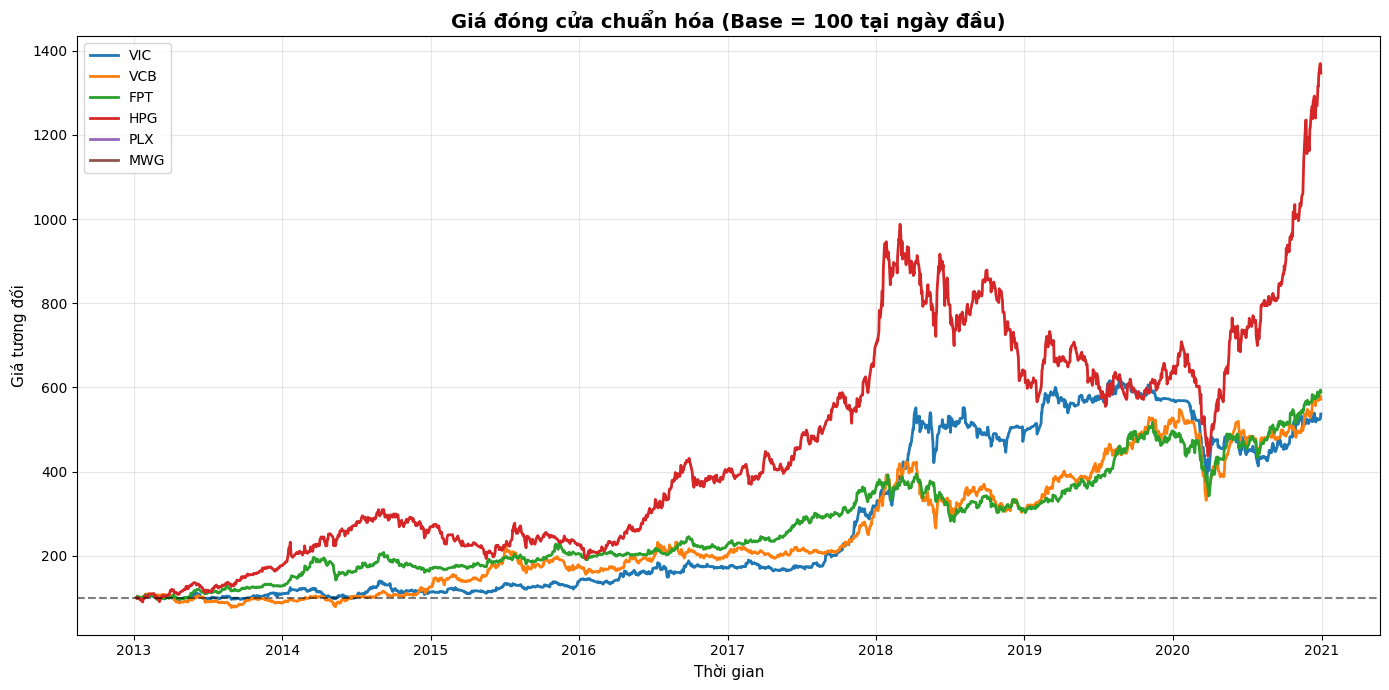

In [23]:
# Vẽ biểu đồ giá cổ phiếu
plt.figure(figsize=(14, 7))

for symbol in prices.columns:
    plt.plot(prices.index, prices[symbol], label=symbol, linewidth=2)

plt.title('Giá đóng cửa 6 mã cổ phiếu vốn hóa lớn (2013-2020)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Thời gian', fontsize=11)
plt.ylabel('Giá (VNĐ)', fontsize=11)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Vẽ biểu đồ chuẩn hóa (normalize về 100)
prices_normalized = (prices / prices.iloc[0]) * 100

plt.figure(figsize=(14, 7))
for symbol in prices_normalized.columns:
    plt.plot(prices_normalized.index, prices_normalized[symbol], 
             label=symbol, linewidth=2)

plt.title('Giá đóng cửa chuẩn hóa (Base = 100 tại ngày đầu)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Thời gian', fontsize=11)
plt.ylabel('Giá tương đối', fontsize=11)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.axhline(y=100, color='black', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Bước 5: Thống kê mô tả

In [24]:
# Thống kê mô tả
print("📊 THỐNG KÊ MÔ TẢ GIÁ CỔ PHIẾU")
print("="*70)
print(prices.describe())

# Tính toán thêm một số chỉ số
print("\n\n📈 CHỈ SỐ BỔ SUNG")
print("="*70)

stats = pd.DataFrame({
    'Giá trung bình': prices.mean(),
    'Giá cao nhất': prices.max(),
    'Giá thấp nhất': prices.min(),
    'Biên độ (max-min)': prices.max() - prices.min(),
    'Độ lệch chuẩn': prices.std(),
    'Hệ số biến động (CV%)': (prices.std() / prices.mean() * 100).round(2)
})

print(stats.sort_values('Hệ số biến động (CV%)', ascending=False))

📊 THỐNG KÊ MÔ TẢ GIÁ CỔ PHIẾU
               VIC          VCB          FPT          HPG         PLX  \
count  1993.000000  1993.000000  1993.000000  1993.000000  929.000000   
mean     50.211520    18.947677    11.840793     5.859413   46.138988   
std      33.475241    10.485265     5.333044     3.375779    6.615664   
min      17.120000     5.720000     4.050000     1.150000   28.950000   
25%      21.130000    10.170000     7.800000     3.010000   42.480000   
50%      30.930000    15.470000     9.980000     5.070000   45.890000   
75%      86.850000    27.380000    15.570000     8.340000   49.100000   
max     112.090000    43.180000    25.600000    17.530000   68.280000   

               MWG  
count  1621.000000  
mean     21.291666  
std       9.829006  
min       4.280000  
25%       9.720000  
50%      23.970000  
75%      28.040000  
max      40.370000  


📈 CHỈ SỐ BỔ SUNG
     Giá trung bình  Giá cao nhất  Giá thấp nhất  Biên độ (max-min)  \
VIC       50.211520        112.09

## Bước 6: Lưu dữ liệu ra file CSV (optional)

In [25]:
# Lưu dữ liệu giá đóng cửa
output_file = 'data/stock_prices_2013_2020.csv'
prices.to_csv(output_file)
print(f"✅ Đã lưu dữ liệu vào: {output_file}")

# Lưu dữ liệu chi tiết của từng mã (nếu cần)
for symbol, df in data_dict.items():
    filename = f'data/{symbol}_detail_2013_2020.csv'
    df.to_csv(filename, index=False)
    print(f"✅ Đã lưu {symbol}: {filename}")

✅ Đã lưu dữ liệu vào: data/stock_prices_2013_2020.csv
✅ Đã lưu VIC: data/VIC_detail_2013_2020.csv
✅ Đã lưu VCB: data/VCB_detail_2013_2020.csv
✅ Đã lưu FPT: data/FPT_detail_2013_2020.csv
✅ Đã lưu HPG: data/HPG_detail_2013_2020.csv
✅ Đã lưu PLX: data/PLX_detail_2013_2020.csv
✅ Đã lưu MWG: data/MWG_detail_2013_2020.csv


## Bước 7: Correlation Analysis - Heatmap giữa các mã cổ phiếu

📊 MA TRẬN CORRELATION (Từ Daily Returns)
        VIC     VCB     FPT     HPG     PLX     MWG
VIC  1.0000  0.9252  0.8817  0.8500  0.0446  0.8665
VCB  0.9252  1.0000  0.9724  0.8711 -0.0720  0.8776
FPT  0.8817  0.9724  1.0000  0.8859 -0.1494  0.8994
HPG  0.8500  0.8711  0.8859  1.0000  0.2886  0.8336
PLX  0.0446 -0.0720 -0.1494  0.2886  1.0000  0.1737
MWG  0.8665  0.8776  0.8994  0.8336  0.1737  1.0000


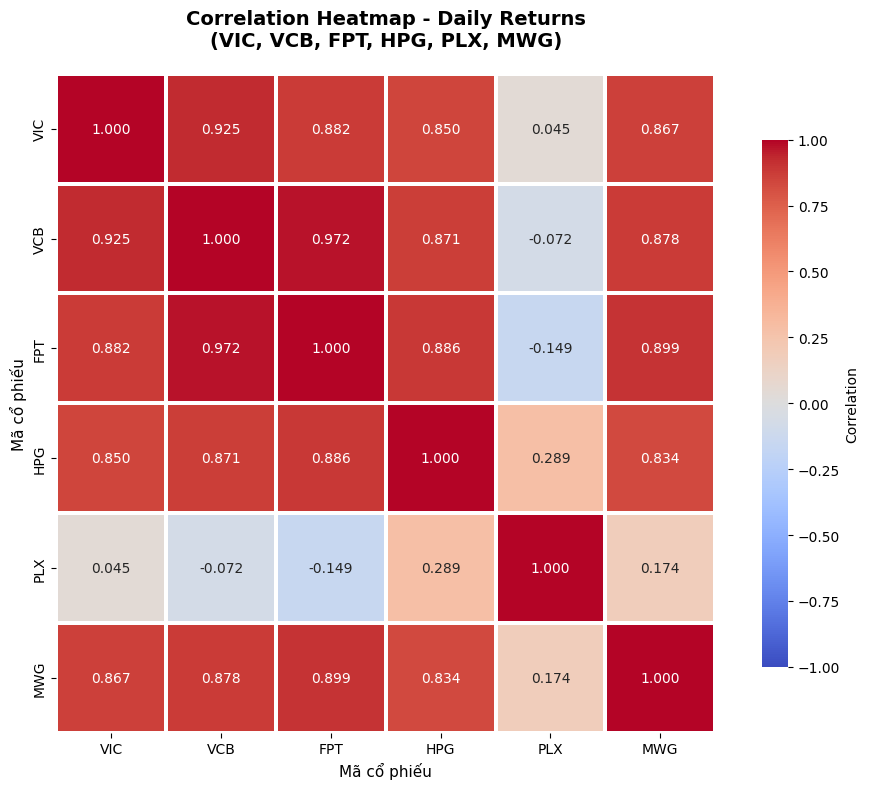


📈 PHÂN TÍCH CORRELATION

🔺 TOP 5 CẶP CÓ CORRELATION CAO NHẤT:
1. VCB - FPT: 0.9724
2. VIC - VCB: 0.9252
3. FPT - MWG: 0.8994
4. FPT - HPG: 0.8859
5. VIC - FPT: 0.8817

🔻 TOP 5 CẶP CÓ CORRELATION THẤP NHẤT:
1. FPT - PLX: -0.1494
2. VCB - PLX: -0.0720
3. VIC - PLX: 0.0446
4. PLX - MWG: 0.1737
5. HPG - PLX: 0.2886

📊 THỐNG KÊ CORRELATION
Average Correlation: 0.6099
Max Correlation: 0.9724
Min Correlation: -0.1494
Std Correlation: 0.4169


In [27]:
# Tính correlation matrix từ returns
correlation_matrix = prices.corr()

print("="*70)
print("📊 MA TRẬN CORRELATION (Từ Daily Returns)")
print("="*70)
print(correlation_matrix.round(4))

# Vẽ heatmap correlation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, 
            annot=True,           # Hiển thị giá trị số
            fmt=".3f",            # Format 3 chữ số thập phân
            cmap="coolwarm",      # Bảng màu: xanh (âm) -> trắng (0) -> đỏ (dương)
            vmin=-1, vmax=1,      # Giới hạn từ -1 đến 1
            square=True,          # Ô vuông
            linewidths=1.5,       # Đường viền giữa các ô
            cbar_kws={"shrink": 0.8, "label": "Correlation"},
            center=0)             # Center tại 0

plt.title('Correlation Heatmap - Daily Returns\n(VIC, VCB, FPT, HPG, PLX, MWG)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Mã cổ phiếu', fontsize=11)
plt.ylabel('Mã cổ phiếu', fontsize=11)
plt.tight_layout()
plt.show()

# Phân tích các cặp có correlation cao/thấp
print("\n" + "="*70)
print("📈 PHÂN TÍCH CORRELATION")
print("="*70)

# Lấy upper triangle (không tính đường chéo)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
corr_upper = correlation_matrix.where(~mask)

# Top 5 cặp có correlation cao nhất
print("\n🔺 TOP 5 CẶP CÓ CORRELATION CAO NHẤT:")
corr_pairs = corr_upper.unstack()
corr_pairs = corr_pairs.dropna()
top_corr = corr_pairs.sort_values(ascending=False).head(5)
for idx, ((stock1, stock2), value) in enumerate(top_corr.items(), 1):
    print(f"{idx}. {stock1} - {stock2}: {value:.4f}")

# Top 5 cặp có correlation thấp nhất
print("\n🔻 TOP 5 CẶP CÓ CORRELATION THẤP NHẤT:")
bottom_corr = corr_pairs.sort_values(ascending=True).head(5)
for idx, ((stock1, stock2), value) in enumerate(bottom_corr.items(), 1):
    print(f"{idx}. {stock1} - {stock2}: {value:.4f}")

# Thống kê tổng quan
print("\n" + "="*70)
print("📊 THỐNG KÊ CORRELATION")
print("="*70)
print(f"Average Correlation: {corr_pairs.mean():.4f}")
print(f"Max Correlation: {corr_pairs.max():.4f}")
print(f"Min Correlation: {corr_pairs.min():.4f}")
print(f"Std Correlation: {corr_pairs.std():.4f}")

## Bước 8: Efficient Frontier - Đường biên hiệu quả

In [28]:
import numpy as np

# Tính returns nếu chưa có
if 'returns' not in locals():
    returns = prices.pct_change().dropna()
    mean_returns = returns.mean() * 252  # Annualized
    cov_matrix = returns.cov() * 252  # Annualized

# Hàm tính portfolio statistics
def portfolio_stats(weights, mean_returns, cov_matrix):
    """Tính return và risk của portfolio"""
    portfolio_return = np.sum(mean_returns * weights) * 100  # Convert to %
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * 100  # Convert to %
    return portfolio_return, portfolio_std

# Simulate random portfolios để vẽ Efficient Frontier
num_portfolios = 10000
results = np.zeros((3, num_portfolios))
weights_record = []

print(f"🔄 Đang tạo {num_portfolios:,} random portfolios...")

np.random.seed(42)
for i in range(num_portfolios):
    # Random weights
    weights = np.random.random(len(prices.columns))
    weights /= np.sum(weights)  # Normalize to sum = 1
    weights_record.append(weights)
    
    # Calculate portfolio return and std
    portfolio_return, portfolio_std = portfolio_stats(weights, mean_returns, cov_matrix)
    
    # Calculate Sharpe ratio
    sharpe_ratio = (portfolio_return - 5) / portfolio_std  # Risk-free rate = 5%
    
    # Store results
    results[0,i] = portfolio_std
    results[1,i] = portfolio_return
    results[2,i] = sharpe_ratio

print("✅ Hoàn thành simulation!")

# Tìm portfolio có Sharpe ratio cao nhất và volatility thấp nhất
max_sharpe_idx = np.argmax(results[2])
min_vol_idx = np.argmin(results[0])

print(f"\n📊 Portfolio tối ưu từ simulation:")
print(f"  Max Sharpe Ratio: Return={results[1,max_sharpe_idx]:.2f}%, Risk={results[0,max_sharpe_idx]:.2f}%, Sharpe={results[2,max_sharpe_idx]:.3f}")
print(f"  Min Volatility: Return={results[1,min_vol_idx]:.2f}%, Risk={results[0,min_vol_idx]:.2f}%, Sharpe={results[2,min_vol_idx]:.3f}")

🔄 Đang tạo 10,000 random portfolios...
✅ Hoàn thành simulation!

📊 Portfolio tối ưu từ simulation:
  Max Sharpe Ratio: Return=34.82%, Risk=22.01%, Sharpe=1.355
  Min Volatility: Return=31.55%, Risk=20.73%, Sharpe=1.281


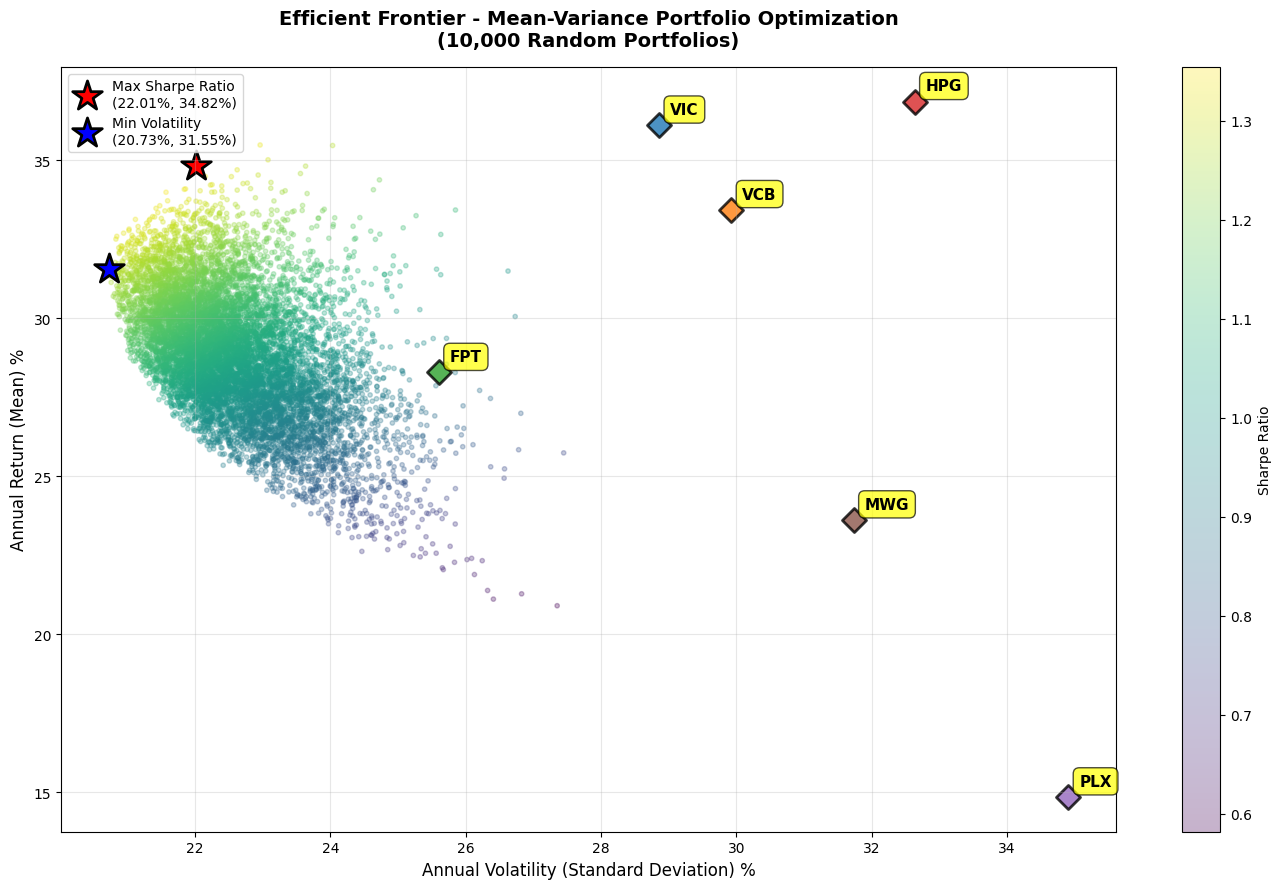

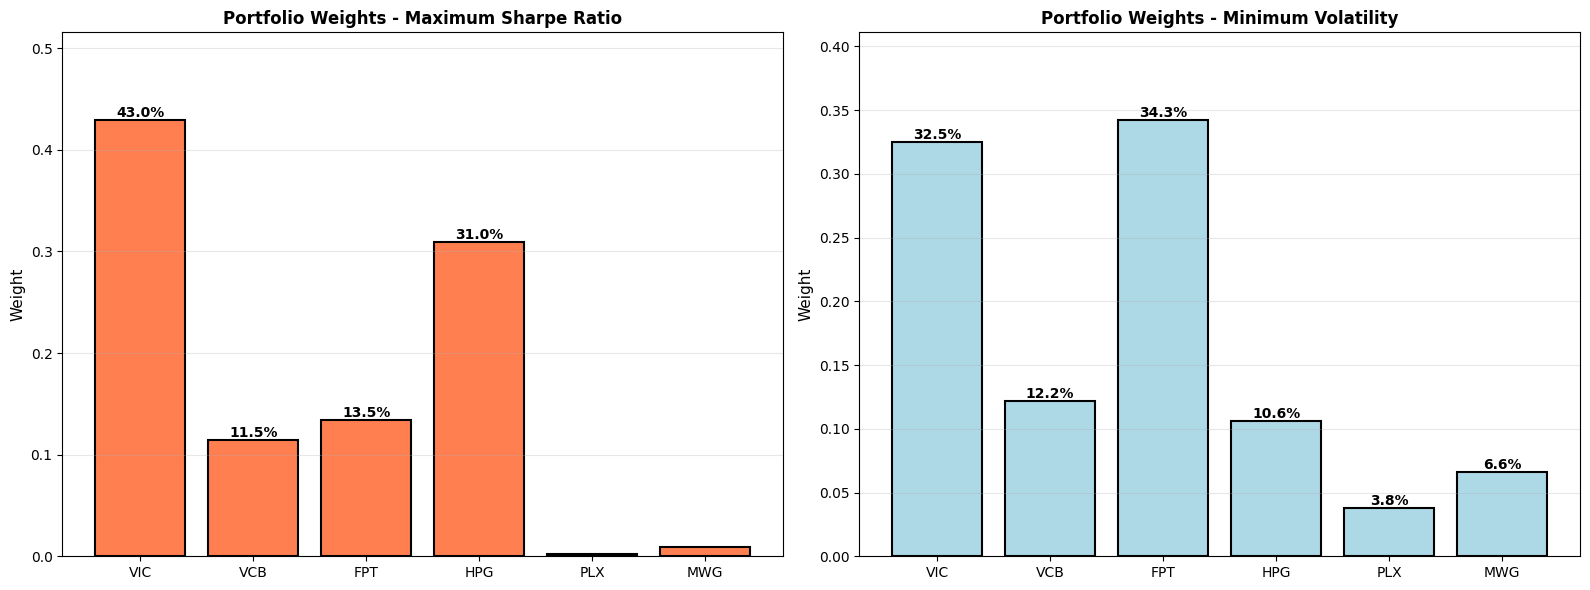


📊 TRỌNG SỐ PORTFOLIO TỐI ƯU
     Max Sharpe  Min Volatility
VIC      0.4296          0.3251
VCB      0.1147          0.1221
FPT      0.1345          0.3426
HPG      0.3095          0.1058
PLX      0.0022          0.0378
MWG      0.0095          0.0665


In [29]:
# Vẽ Efficient Frontier
plt.figure(figsize=(14, 9))

# Scatter plot của random portfolios - màu theo Sharpe ratio
scatter = plt.scatter(results[0,:], results[1,:], 
                     c=results[2,:], cmap='viridis', 
                     marker='o', s=10, alpha=0.3)
plt.colorbar(scatter, label='Sharpe Ratio')

# Highlight Max Sharpe Portfolio
plt.scatter(results[0,max_sharpe_idx], results[1,max_sharpe_idx], 
           marker='*', color='red', s=500, edgecolors='black', linewidth=2,
           label=f'Max Sharpe Ratio\n({results[0,max_sharpe_idx]:.2f}%, {results[1,max_sharpe_idx]:.2f}%)')

# Highlight Min Volatility Portfolio
plt.scatter(results[0,min_vol_idx], results[1,min_vol_idx], 
           marker='*', color='blue', s=500, edgecolors='black', linewidth=2,
           label=f'Min Volatility\n({results[0,min_vol_idx]:.2f}%, {results[1,min_vol_idx]:.2f}%)')

# Plot individual stocks
for stock in prices.columns:
    stock_return = mean_returns[stock] * 100
    stock_vol = np.sqrt(cov_matrix.loc[stock, stock]) * 100
    plt.scatter(stock_vol, stock_return, marker='D', s=150, 
               edgecolors='black', linewidth=2, alpha=0.8)
    plt.annotate(stock, (stock_vol, stock_return), 
                xytext=(8, 8), textcoords='offset points',
                fontsize=11, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.4', fc='yellow', alpha=0.7))

plt.title('Efficient Frontier - Mean-Variance Portfolio Optimization\n(10,000 Random Portfolios)', 
          fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Annual Volatility (Standard Deviation) %', fontsize=12)
plt.ylabel('Annual Return (Mean) %', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Vẽ biểu đồ trọng số của portfolio tối ưu
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Max Sharpe Portfolio weights
max_sharpe_weights = weights_record[max_sharpe_idx]
ax1.bar(prices.columns, max_sharpe_weights, color='coral', edgecolor='black', linewidth=1.5)
ax1.set_title('Portfolio Weights - Maximum Sharpe Ratio', fontsize=12, fontweight='bold')
ax1.set_ylabel('Weight', fontsize=11)
ax1.set_ylim(0, max(max_sharpe_weights) * 1.2)
ax1.grid(axis='y', alpha=0.3)
for i, (stock, weight) in enumerate(zip(prices.columns, max_sharpe_weights)):
    if weight > 0.01:
        ax1.text(i, weight, f'{weight:.1%}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Min Volatility Portfolio weights
min_vol_weights = weights_record[min_vol_idx]
ax2.bar(prices.columns, min_vol_weights, color='lightblue', edgecolor='black', linewidth=1.5)
ax2.set_title('Portfolio Weights - Minimum Volatility', fontsize=12, fontweight='bold')
ax2.set_ylabel('Weight', fontsize=11)
ax2.set_ylim(0, max(min_vol_weights) * 1.2)
ax2.grid(axis='y', alpha=0.3)
for i, (stock, weight) in enumerate(zip(prices.columns, min_vol_weights)):
    if weight > 0.01:
        ax2.text(i, weight, f'{weight:.1%}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("📊 TRỌNG SỐ PORTFOLIO TỐI ƯU")
print("="*70)
optimal_weights_df = pd.DataFrame({
    'Max Sharpe': max_sharpe_weights,
    'Min Volatility': min_vol_weights
}, index=prices.columns)
print(optimal_weights_df.round(4))